In [220]:
import math

import random

from collections import defaultdict

import matplotlib.pyplot as plt

%matplotlib inline

### Data Preparation

In [235]:
def read_csv(path, train_test_ratio=.8):
    
    with open(path) as f:
        lines = f.readlines()[1:]
        
    random.shuffle(lines)
    
    x, y = [], []    
        
    for line in lines:                        
        if 'NA' in line:
            continue
        
        line = line.split(',')
        
        features = line[:4]
        features[1] = float(features[1])
        features[2] = float(features[2])
        features[3] = float(features[3])                
        
        line[4] = 1 if line[4].strip() == '"TRUE"' else 0
        
        x.append(features)
        y.append(line[4])
    
    train_set_size = int(len(x) * train_test_ratio)           
    
    train_x = x[:train_set_size]
    train_y = y[:train_set_size]
    test_x = x[train_set_size:]
    test_y = y[train_set_size:]        
    
        
    return train_x, train_y, test_x, test_y

In [236]:
x_train, y_train, x_test, y_test = read_csv('dataset/seattleWeather_1948-2017.csv')

In [237]:
# inspect data for normalization

mins = [float('inf')] * 3
maxs = [float('-inf')] * 3

for line in train_x:    
    for i, value in enumerate(line[1:]):
        mins[i] = min(mins[i], value)
        maxs[i] = max(maxs[i], value)

        
mins, maxs

([0.0, 4.0, 0.0], [3.77, 103.0, 71.0])

In [250]:
# normalize input

def prepare(x):
    x = x[1:]
    
#     for i in range(len(x)):
#         x[i] = (x[i] - mins[i]) / (maxs[i] - mins[i])
    
    return x

In [251]:
x_train_normalized = []

for x in train_x:
    x_train_normalized.append(prepare(x))


### Naive Bayes

In [252]:
# count frequecy of each number in the dataset

class_frequency = {0: 0, 1: 0}

for label in y_train:
    class_frequency[label] += 1

class_frequency

{0: 11722, 1: 8716}

In [253]:
# calculate prior

prior = {}

dataset_size = len(y_train)

for class_ in range(2):
    prior[class_] = class_frequency[class_] / dataset_size

prior

{0: 0.5735394852725315, 1: 0.42646051472746843}

In [254]:
# calculate mean and variance for each feature

n_features = len(x_train_normalized[0])

mean = defaultdict(lambda : [0] * n_features)

for sample, label in zip(x_train_normalized, y_train):
    for idx, feature in enumerate(sample):
        mean[label][idx] += feature
        
for value in mean.values():
    for idx in range(len(value)):
        value[idx] /= dataset_size

mean

defaultdict(<function __main__.<lambda>()>,
            {1: [0.04476367550640909, 25.390742734122714, 19.003278207260983],
             0: [0.059696643507191234, 34.21019669243566, 25.534396712007045]})

In [255]:
# varience

varience = defaultdict(lambda : [0] * n_features)

for sample, label in zip(x_train_normalized, y_train):
    for idx, feature in enumerate(sample):
        varience[label][idx] += (feature - mean[label][idx]) ** 2

        
for value in varience.values():
    for idx in range(len(value)):
        value[idx] /= dataset_size  

varience

defaultdict(<function __main__.<lambda>()>,
            {1: [0.024435435047548693, 565.7207896297342, 312.2166759398423],
             0: [0.03354310616114135, 465.6540190718237, 252.27214590873672]})

In [256]:
def gausian_probability(xs, mean, var, smoothing):
    probability = []
        
    for idx, x in enumerate(xs):
        m = mean[idx]
        v = var[idx] + smoothing
        
        prob = 1 / math.sqrt(2 * math.pi * v) * math.exp(-(x - m) ** 2 / (2 * v))            
        
        probability.append(math.log(prob))
    
    return sum(probability)


def argmax(values):
    max_value = float('-inf')
    max_index = 0

    for idx, value in enumerate(values):
        if value > max_value:
            max_index = idx
            max_value = value

    return max_index

In [257]:
def predict_naive_bayes(sample, smoothing):    
    gaussians_likelihood = [0] * 2
    
    for cls in range(2):
        m = mean[cls]
        var = varience[cls]
        
        probability = gausian_probability(sample, m, var, smoothing)               
        
        probability += math.log(prior[cls])
        
        gaussians_likelihood[cls] = probability        
    
    return argmax(gaussians_likelihood)
        

In [258]:
def test(x_test, y_test, smoothing):    
    confussion_matrix = [[0] * 2 for _ in range(2)]
    net_accuracy = 0

    for i in range(len(x_test)):
        prediction = predict_naive_bayes(x_test[i], smoothing)

        confussion_matrix[prediction][y_test[i]] += 1

        if prediction == y_test[i]:
            net_accuracy += 1

    return confussion_matrix, net_accuracy / len(x_test)

In [273]:
# test

smoothings = [0.01, 0.1, 0.5, 1.0, 10, 100]

x_test_normalized = list(map(prepare, x_test))

scores = []

for smoothing in smoothings:
    cm, acc = test(x_test_normalized, y_test, smoothing)
    
    scores.append((cm, acc))


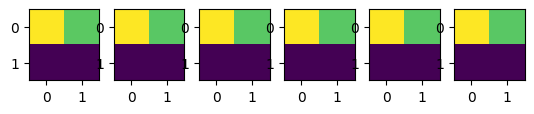

In [274]:
# draw confussion matrix

fig, axs = plt.subplots(nrows=1, ncols=len(smoothings))
    
for i, ax in enumerate(axs.flat):
    
    ax.set_label(smoothings[i])

    ax.imshow(scores[i][0])
    

In [275]:
# Accuracy

for i in range(len(scores)):
    print(f'Smoothing: {smoothings[i]} \tAccuracy: {scores[i][1]}')

Smoothing: 0.01 	Accuracy: 0.5718199608610568
Smoothing: 0.1 	Accuracy: 0.5726027397260274
Smoothing: 0.5 	Accuracy: 0.5726027397260274
Smoothing: 1.0 	Accuracy: 0.5727984344422701
Smoothing: 10 	Accuracy: 0.5727984344422701
Smoothing: 100 	Accuracy: 0.5727984344422701
